# Generating Images of Cats and Dogs -- Group 35
## GAN
Gustav Lahti (lahtig@student.chalmers.se) and Agnes Mårdh (agnesma@student.chalmers.se) 

## Imports
Importing all the necessary libraries and other useful initialisations.

In [1]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as vutils

import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np

import matplotlib.pyplot as plt

# Just for benchmarking
import time

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Defining various hyperparameters

In [2]:
# Root for images
dataroot = "train"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 300

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

## Initializing DataSet and DataLoader
We are using the same folder structure as for home assignment 1.

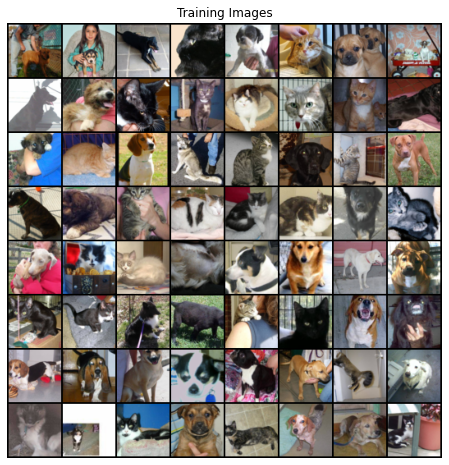

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator

In [5]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [7]:
# Create the generator
netG = Generator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

## Discriminator

In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

## Training loop

In [10]:
def train(netG, netD, lr=lr, num_epochs=num_epochs):
    # Initialize BCELoss function
    criterion = nn.BCELoss()

    # Create batch of latent vectors that we will use to visualize
    #  the progression of the generator
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)

    # Establish convention for real and fake labels during training
    real_label = 1.
    fake_label = 0.

    # Setup Adam optimizers for both G and D
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
    
    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    print("Starting Training Loop...")

    # Reference time point for how long the training takes
    start_time = time.perf_counter()

    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Add the gradients from the all-real and all-fake batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1

    # Calculate the amount of time the training took
    elapsed_time = time.perf_counter() - start_time
    
    return img_list, G_losses, D_losses, elapsed_time

In [11]:
def print_elapsed_time(elapsed_time):
    return "{:.0f}h {:02.0f}m {:.3f}s".format(elapsed_time // 3600,
                                              elapsed_time % 3600 // 60,
                                              elapsed_time % 60)

In [12]:
def plot_losses(G_losses, D_losses):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [13]:
def animate_progress(img_list):
    #%%capture
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

    HTML(ani.to_jshtml())

In [14]:
def compare_real_gen(dataloader, img_list):
    # Grab a batch of real images from the dataloader
    real_batch = next(iter(dataloader))

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    plt.show()

## Train the GAN

In [15]:
img_list, G_losses, D_losses, elapsed_time = train(netG, netD, num_epochs=num_epochs)

Starting Training Loop...
[0/300][0/184]	Loss_D: 1.5989	Loss_G: 6.8555	D(x): 0.5448	D(G(z)): 0.5215 / 0.0018
[0/300][50/184]	Loss_D: 0.6672	Loss_G: 22.5055	D(x): 0.7234	D(G(z)): 0.0000 / 0.0000
[0/300][100/184]	Loss_D: 0.7646	Loss_G: 4.9707	D(x): 0.8774	D(G(z)): 0.4346 / 0.0136
[0/300][150/184]	Loss_D: 1.8893	Loss_G: 1.2449	D(x): 0.2472	D(G(z)): 0.0532 / 0.3814
[1/300][0/184]	Loss_D: 1.3797	Loss_G: 7.2881	D(x): 0.9230	D(G(z)): 0.6850 / 0.0009
[1/300][50/184]	Loss_D: 0.3144	Loss_G: 4.2988	D(x): 0.8470	D(G(z)): 0.0778 / 0.0195
[1/300][100/184]	Loss_D: 0.6086	Loss_G: 6.5832	D(x): 0.8750	D(G(z)): 0.2688 / 0.0036
[1/300][150/184]	Loss_D: 0.5435	Loss_G: 2.7125	D(x): 0.9293	D(G(z)): 0.2953 / 0.1176
[2/300][0/184]	Loss_D: 1.0673	Loss_G: 6.8877	D(x): 0.8815	D(G(z)): 0.5258 / 0.0027
[2/300][50/184]	Loss_D: 0.7732	Loss_G: 3.5542	D(x): 0.7053	D(G(z)): 0.2372 / 0.0470
[2/300][100/184]	Loss_D: 0.6433	Loss_G: 2.0225	D(x): 0.6555	D(G(z)): 0.1287 / 0.1919
[2/300][150/184]	Loss_D: 0.2271	Loss_G: 3.6492	

[24/300][50/184]	Loss_D: 0.3442	Loss_G: 3.1688	D(x): 0.8406	D(G(z)): 0.1334 / 0.0565
[24/300][100/184]	Loss_D: 0.6219	Loss_G: 2.4120	D(x): 0.7069	D(G(z)): 0.1738 / 0.1348
[24/300][150/184]	Loss_D: 0.3973	Loss_G: 3.1325	D(x): 0.8685	D(G(z)): 0.2004 / 0.0608
[25/300][0/184]	Loss_D: 0.6291	Loss_G: 5.7564	D(x): 0.9713	D(G(z)): 0.3996 / 0.0053
[25/300][50/184]	Loss_D: 0.5753	Loss_G: 1.8373	D(x): 0.6338	D(G(z)): 0.0543 / 0.2227
[25/300][100/184]	Loss_D: 1.0268	Loss_G: 5.2860	D(x): 0.9637	D(G(z)): 0.5529 / 0.0099
[25/300][150/184]	Loss_D: 0.4653	Loss_G: 4.1364	D(x): 0.9012	D(G(z)): 0.2709 / 0.0224
[26/300][0/184]	Loss_D: 0.4875	Loss_G: 3.9020	D(x): 0.9457	D(G(z)): 0.3183 / 0.0286
[26/300][50/184]	Loss_D: 0.3470	Loss_G: 3.0649	D(x): 0.8504	D(G(z)): 0.1491 / 0.0652
[26/300][100/184]	Loss_D: 0.3716	Loss_G: 2.3137	D(x): 0.8124	D(G(z)): 0.1290 / 0.1239
[26/300][150/184]	Loss_D: 0.4717	Loss_G: 2.4867	D(x): 0.8029	D(G(z)): 0.1832 / 0.1141
[27/300][0/184]	Loss_D: 1.8751	Loss_G: 6.6580	D(x): 0.9776	D(

[48/300][100/184]	Loss_D: 0.5330	Loss_G: 1.2758	D(x): 0.6603	D(G(z)): 0.0777 / 0.3419
[48/300][150/184]	Loss_D: 0.6545	Loss_G: 3.6253	D(x): 0.9179	D(G(z)): 0.3821 / 0.0370
[49/300][0/184]	Loss_D: 0.3360	Loss_G: 2.9913	D(x): 0.8591	D(G(z)): 0.1497 / 0.0726
[49/300][50/184]	Loss_D: 0.4438	Loss_G: 2.5975	D(x): 0.8227	D(G(z)): 0.1887 / 0.0999
[49/300][100/184]	Loss_D: 0.3126	Loss_G: 2.7806	D(x): 0.8621	D(G(z)): 0.1368 / 0.0821
[49/300][150/184]	Loss_D: 1.1962	Loss_G: 1.2058	D(x): 0.3802	D(G(z)): 0.0501 / 0.3926
[50/300][0/184]	Loss_D: 0.6544	Loss_G: 3.4927	D(x): 0.7960	D(G(z)): 0.2926 / 0.0483
[50/300][50/184]	Loss_D: 0.5546	Loss_G: 1.0733	D(x): 0.6753	D(G(z)): 0.0978 / 0.3925
[50/300][100/184]	Loss_D: 0.5571	Loss_G: 3.8854	D(x): 0.8859	D(G(z)): 0.3105 / 0.0302
[50/300][150/184]	Loss_D: 0.4033	Loss_G: 3.0710	D(x): 0.9096	D(G(z)): 0.2302 / 0.0668
[51/300][0/184]	Loss_D: 0.7455	Loss_G: 2.1127	D(x): 0.5249	D(G(z)): 0.0112 / 0.1716
[51/300][50/184]	Loss_D: 0.3737	Loss_G: 4.5069	D(x): 0.9274	D(

[72/300][150/184]	Loss_D: 1.4366	Loss_G: 2.9877	D(x): 0.7236	D(G(z)): 0.5375 / 0.0882
[73/300][0/184]	Loss_D: 0.5825	Loss_G: 4.5969	D(x): 0.9173	D(G(z)): 0.3362 / 0.0155
[73/300][50/184]	Loss_D: 0.6922	Loss_G: 1.7113	D(x): 0.5764	D(G(z)): 0.0492 / 0.2473
[73/300][100/184]	Loss_D: 0.2301	Loss_G: 3.5451	D(x): 0.8919	D(G(z)): 0.0973 / 0.0441
[73/300][150/184]	Loss_D: 0.1842	Loss_G: 2.8073	D(x): 0.8837	D(G(z)): 0.0525 / 0.1020
[74/300][0/184]	Loss_D: 0.1426	Loss_G: 3.6340	D(x): 0.9225	D(G(z)): 0.0534 / 0.0412
[74/300][50/184]	Loss_D: 0.2472	Loss_G: 3.3637	D(x): 0.8929	D(G(z)): 0.1122 / 0.0533
[74/300][100/184]	Loss_D: 0.3379	Loss_G: 2.0344	D(x): 0.8590	D(G(z)): 0.1407 / 0.1893
[74/300][150/184]	Loss_D: 0.3429	Loss_G: 2.6137	D(x): 0.7905	D(G(z)): 0.0613 / 0.1075
[75/300][0/184]	Loss_D: 0.2749	Loss_G: 2.8107	D(x): 0.8115	D(G(z)): 0.0432 / 0.0954
[75/300][50/184]	Loss_D: 0.1779	Loss_G: 3.6379	D(x): 0.9195	D(G(z)): 0.0831 / 0.0396
[75/300][100/184]	Loss_D: 0.2303	Loss_G: 3.7982	D(x): 0.9305	D(

[97/300][0/184]	Loss_D: 0.1365	Loss_G: 5.2850	D(x): 0.9847	D(G(z)): 0.1041 / 0.0087
[97/300][50/184]	Loss_D: 0.1425	Loss_G: 4.2455	D(x): 0.9567	D(G(z)): 0.0856 / 0.0236
[97/300][100/184]	Loss_D: 2.3825	Loss_G: 8.6070	D(x): 0.9924	D(G(z)): 0.8213 / 0.0005
[97/300][150/184]	Loss_D: 0.4898	Loss_G: 3.5731	D(x): 0.7957	D(G(z)): 0.1367 / 0.0555
[98/300][0/184]	Loss_D: 0.1720	Loss_G: 4.4725	D(x): 0.9782	D(G(z)): 0.1246 / 0.0197
[98/300][50/184]	Loss_D: 0.1984	Loss_G: 3.7517	D(x): 0.9132	D(G(z)): 0.0941 / 0.0347
[98/300][100/184]	Loss_D: 0.1988	Loss_G: 4.5981	D(x): 0.9430	D(G(z)): 0.1178 / 0.0164
[98/300][150/184]	Loss_D: 0.4513	Loss_G: 5.8359	D(x): 0.9783	D(G(z)): 0.2893 / 0.0046
[99/300][0/184]	Loss_D: 0.1188	Loss_G: 4.3458	D(x): 0.9402	D(G(z)): 0.0496 / 0.0232
[99/300][50/184]	Loss_D: 0.1138	Loss_G: 4.3903	D(x): 0.9398	D(G(z)): 0.0470 / 0.0234
[99/300][100/184]	Loss_D: 0.1427	Loss_G: 4.1313	D(x): 0.9404	D(G(z)): 0.0729 / 0.0261
[99/300][150/184]	Loss_D: 0.3937	Loss_G: 2.7843	D(x): 0.7693	D(

[121/300][0/184]	Loss_D: 0.3774	Loss_G: 4.3162	D(x): 0.9404	D(G(z)): 0.2155 / 0.0237
[121/300][50/184]	Loss_D: 0.2645	Loss_G: 2.9007	D(x): 0.8211	D(G(z)): 0.0407 / 0.0998
[121/300][100/184]	Loss_D: 0.1550	Loss_G: 4.4091	D(x): 0.9565	D(G(z)): 0.0938 / 0.0204
[121/300][150/184]	Loss_D: 0.1323	Loss_G: 4.4645	D(x): 0.9561	D(G(z)): 0.0752 / 0.0225
[122/300][0/184]	Loss_D: 0.4377	Loss_G: 6.3535	D(x): 0.9939	D(G(z)): 0.3010 / 0.0033
[122/300][50/184]	Loss_D: 0.0842	Loss_G: 4.3741	D(x): 0.9436	D(G(z)): 0.0240 / 0.0240
[122/300][100/184]	Loss_D: 0.1074	Loss_G: 4.4830	D(x): 0.9751	D(G(z)): 0.0731 / 0.0211
[122/300][150/184]	Loss_D: 0.0729	Loss_G: 4.2884	D(x): 0.9719	D(G(z)): 0.0415 / 0.0264
[123/300][0/184]	Loss_D: 0.0668	Loss_G: 4.3576	D(x): 0.9646	D(G(z)): 0.0289 / 0.0236
[123/300][50/184]	Loss_D: 0.0959	Loss_G: 3.9376	D(x): 0.9360	D(G(z)): 0.0264 / 0.0351
[123/300][100/184]	Loss_D: 0.0599	Loss_G: 5.4530	D(x): 0.9672	D(G(z)): 0.0253 / 0.0088
[123/300][150/184]	Loss_D: 0.0765	Loss_G: 4.4879	D(x

[144/300][150/184]	Loss_D: 0.0583	Loss_G: 4.9088	D(x): 0.9829	D(G(z)): 0.0375 / 0.0125
[145/300][0/184]	Loss_D: 0.0500	Loss_G: 5.1001	D(x): 0.9769	D(G(z)): 0.0249 / 0.0131
[145/300][50/184]	Loss_D: 0.0446	Loss_G: 5.1506	D(x): 0.9870	D(G(z)): 0.0297 / 0.0114
[145/300][100/184]	Loss_D: 0.0773	Loss_G: 5.7462	D(x): 0.9955	D(G(z)): 0.0648 / 0.0062
[145/300][150/184]	Loss_D: 0.0589	Loss_G: 5.5217	D(x): 0.9857	D(G(z)): 0.0383 / 0.0083
[146/300][0/184]	Loss_D: 1.9756	Loss_G: 1.7985	D(x): 0.6279	D(G(z)): 0.5192 / 0.2582
[146/300][50/184]	Loss_D: 1.3657	Loss_G: 3.4695	D(x): 0.9054	D(G(z)): 0.5883 / 0.0672
[146/300][100/184]	Loss_D: 1.5035	Loss_G: 5.2929	D(x): 0.8779	D(G(z)): 0.5926 / 0.0149
[146/300][150/184]	Loss_D: 0.7865	Loss_G: 8.8932	D(x): 0.9808	D(G(z)): 0.4270 / 0.0006
[147/300][0/184]	Loss_D: 0.1321	Loss_G: 4.9778	D(x): 0.9595	D(G(z)): 0.0753 / 0.0142
[147/300][50/184]	Loss_D: 0.1312	Loss_G: 4.6106	D(x): 0.9234	D(G(z)): 0.0426 / 0.0216
[147/300][100/184]	Loss_D: 0.0996	Loss_G: 4.1468	D(x

[168/300][100/184]	Loss_D: 0.0574	Loss_G: 4.9898	D(x): 0.9684	D(G(z)): 0.0234 / 0.0159
[168/300][150/184]	Loss_D: 0.0554	Loss_G: 5.2814	D(x): 0.9938	D(G(z)): 0.0422 / 0.0113
[169/300][0/184]	Loss_D: 0.0661	Loss_G: 4.4091	D(x): 0.9490	D(G(z)): 0.0125 / 0.0254
[169/300][50/184]	Loss_D: 0.0514	Loss_G: 5.6366	D(x): 0.9825	D(G(z)): 0.0311 / 0.0074
[169/300][100/184]	Loss_D: 0.0432	Loss_G: 5.0286	D(x): 0.9935	D(G(z)): 0.0342 / 0.0112
[169/300][150/184]	Loss_D: 0.0791	Loss_G: 4.4696	D(x): 0.9405	D(G(z)): 0.0149 / 0.0292
[170/300][0/184]	Loss_D: 0.6014	Loss_G: 2.9568	D(x): 0.7503	D(G(z)): 0.1764 / 0.0917
[170/300][50/184]	Loss_D: 0.0644	Loss_G: 6.4819	D(x): 0.9600	D(G(z)): 0.0199 / 0.0047
[170/300][100/184]	Loss_D: 0.0620	Loss_G: 4.7919	D(x): 0.9851	D(G(z)): 0.0433 / 0.0175
[170/300][150/184]	Loss_D: 0.0566	Loss_G: 5.0392	D(x): 0.9701	D(G(z)): 0.0241 / 0.0168
[171/300][0/184]	Loss_D: 0.0776	Loss_G: 5.2880	D(x): 0.9947	D(G(z)): 0.0656 / 0.0099
[171/300][50/184]	Loss_D: 0.0685	Loss_G: 5.1075	D(x

[192/300][50/184]	Loss_D: 0.0351	Loss_G: 5.4080	D(x): 0.9835	D(G(z)): 0.0177 / 0.0105
[192/300][100/184]	Loss_D: 0.0331	Loss_G: 4.7259	D(x): 0.9884	D(G(z)): 0.0206 / 0.0192
[192/300][150/184]	Loss_D: 0.0378	Loss_G: 5.7165	D(x): 0.9943	D(G(z)): 0.0305 / 0.0070
[193/300][0/184]	Loss_D: 0.0433	Loss_G: 5.4429	D(x): 0.9807	D(G(z)): 0.0222 / 0.0116
[193/300][50/184]	Loss_D: 0.0207	Loss_G: 5.7377	D(x): 0.9904	D(G(z)): 0.0109 / 0.0071
[193/300][100/184]	Loss_D: 0.0527	Loss_G: 4.5622	D(x): 0.9727	D(G(z)): 0.0227 / 0.0292
[193/300][150/184]	Loss_D: 1.0763	Loss_G: 1.3145	D(x): 0.5249	D(G(z)): 0.1169 / 0.3503
[194/300][0/184]	Loss_D: 0.2977	Loss_G: 4.2765	D(x): 0.9188	D(G(z)): 0.1414 / 0.0378
[194/300][50/184]	Loss_D: 0.1945	Loss_G: 7.2053	D(x): 0.9531	D(G(z)): 0.1192 / 0.0017
[194/300][100/184]	Loss_D: 0.1186	Loss_G: 3.9797	D(x): 0.9193	D(G(z)): 0.0214 / 0.0475
[194/300][150/184]	Loss_D: 0.0594	Loss_G: 5.4621	D(x): 0.9574	D(G(z)): 0.0134 / 0.0115
[195/300][0/184]	Loss_D: 0.0828	Loss_G: 5.4526	D(x

[216/300][0/184]	Loss_D: 0.0182	Loss_G: 6.2869	D(x): 0.9956	D(G(z)): 0.0127 / 0.0044
[216/300][50/184]	Loss_D: 0.0204	Loss_G: 6.1049	D(x): 0.9897	D(G(z)): 0.0093 / 0.0061
[216/300][100/184]	Loss_D: 0.0246	Loss_G: 5.9491	D(x): 0.9857	D(G(z)): 0.0098 / 0.0067
[216/300][150/184]	Loss_D: 0.0263	Loss_G: 6.3953	D(x): 0.9967	D(G(z)): 0.0219 / 0.0040
[217/300][0/184]	Loss_D: 0.0174	Loss_G: 6.9118	D(x): 0.9891	D(G(z)): 0.0063 / 0.0032
[217/300][50/184]	Loss_D: 0.0159	Loss_G: 6.5459	D(x): 0.9973	D(G(z)): 0.0127 / 0.0039
[217/300][100/184]	Loss_D: 3.8398	Loss_G: 0.7052	D(x): 0.3230	D(G(z)): 0.2552 / 0.6432
[217/300][150/184]	Loss_D: 1.4434	Loss_G: 0.9421	D(x): 0.4721	D(G(z)): 0.3408 / 0.4526
[218/300][0/184]	Loss_D: 0.8539	Loss_G: 1.8152	D(x): 0.6387	D(G(z)): 0.2060 / 0.2387
[218/300][50/184]	Loss_D: 1.1802	Loss_G: 1.8128	D(x): 0.7076	D(G(z)): 0.3949 / 0.2845
[218/300][100/184]	Loss_D: 0.2874	Loss_G: 4.3089	D(x): 0.8733	D(G(z)): 0.0730 / 0.0347
[218/300][150/184]	Loss_D: 0.1632	Loss_G: 4.0222	D(x

[239/300][150/184]	Loss_D: 0.0406	Loss_G: 5.4895	D(x): 0.9893	D(G(z)): 0.0268 / 0.0108
[240/300][0/184]	Loss_D: 0.0367	Loss_G: 6.2106	D(x): 0.9910	D(G(z)): 0.0257 / 0.0056
[240/300][50/184]	Loss_D: 0.0237	Loss_G: 5.9260	D(x): 0.9861	D(G(z)): 0.0094 / 0.0078
[240/300][100/184]	Loss_D: 0.0230	Loss_G: 6.0482	D(x): 0.9869	D(G(z)): 0.0094 / 0.0072
[240/300][150/184]	Loss_D: 0.0205	Loss_G: 6.1334	D(x): 0.9902	D(G(z)): 0.0102 / 0.0066
[241/300][0/184]	Loss_D: 0.0725	Loss_G: 6.6610	D(x): 0.9943	D(G(z)): 0.0532 / 0.0029
[241/300][50/184]	Loss_D: 0.0149	Loss_G: 6.1128	D(x): 0.9955	D(G(z)): 0.0101 / 0.0063
[241/300][100/184]	Loss_D: 0.0204	Loss_G: 6.1840	D(x): 0.9978	D(G(z)): 0.0174 / 0.0056
[241/300][150/184]	Loss_D: 0.0189	Loss_G: 6.2692	D(x): 0.9943	D(G(z)): 0.0127 / 0.0056
[242/300][0/184]	Loss_D: 0.0190	Loss_G: 6.5080	D(x): 0.9848	D(G(z)): 0.0034 / 0.0049
[242/300][50/184]	Loss_D: 0.0272	Loss_G: 6.0861	D(x): 0.9787	D(G(z)): 0.0054 / 0.0075
[242/300][100/184]	Loss_D: 0.0304	Loss_G: 5.9703	D(x

[263/300][100/184]	Loss_D: 0.0236	Loss_G: 7.0042	D(x): 0.9927	D(G(z)): 0.0153 / 0.0028
[263/300][150/184]	Loss_D: 0.0374	Loss_G: 5.6632	D(x): 0.9725	D(G(z)): 0.0084 / 0.0125
[264/300][0/184]	Loss_D: 0.0185	Loss_G: 7.0215	D(x): 0.9945	D(G(z)): 0.0117 / 0.0032
[264/300][50/184]	Loss_D: 0.0244	Loss_G: 6.4642	D(x): 0.9923	D(G(z)): 0.0155 / 0.0040
[264/300][100/184]	Loss_D: 0.0277	Loss_G: 6.3236	D(x): 0.9844	D(G(z)): 0.0103 / 0.0064
[264/300][150/184]	Loss_D: 0.0102	Loss_G: 6.7336	D(x): 0.9965	D(G(z)): 0.0066 / 0.0036
[265/300][0/184]	Loss_D: 0.0199	Loss_G: 6.4178	D(x): 0.9846	D(G(z)): 0.0041 / 0.0059
[265/300][50/184]	Loss_D: 0.0124	Loss_G: 7.0106	D(x): 0.9991	D(G(z)): 0.0104 / 0.0025
[265/300][100/184]	Loss_D: 0.0178	Loss_G: 6.4384	D(x): 0.9940	D(G(z)): 0.0114 / 0.0048
[265/300][150/184]	Loss_D: 1.3901	Loss_G: 2.7779	D(x): 0.8328	D(G(z)): 0.5905 / 0.1015
[266/300][0/184]	Loss_D: 0.4216	Loss_G: 5.4241	D(x): 0.9017	D(G(z)): 0.2031 / 0.0107
[266/300][50/184]	Loss_D: 0.3054	Loss_G: 4.1920	D(x

[287/300][50/184]	Loss_D: 0.0170	Loss_G: 6.5266	D(x): 0.9909	D(G(z)): 0.0076 / 0.0051
[287/300][100/184]	Loss_D: 0.0078	Loss_G: 6.8868	D(x): 0.9972	D(G(z)): 0.0049 / 0.0035
[287/300][150/184]	Loss_D: 0.0507	Loss_G: 4.5029	D(x): 0.9603	D(G(z)): 0.0073 / 0.0406
[288/300][0/184]	Loss_D: 0.0229	Loss_G: 6.4522	D(x): 0.9796	D(G(z)): 0.0019 / 0.0054
[288/300][50/184]	Loss_D: 0.0179	Loss_G: 7.2139	D(x): 0.9980	D(G(z)): 0.0128 / 0.0027
[288/300][100/184]	Loss_D: 0.0131	Loss_G: 6.7954	D(x): 0.9965	D(G(z)): 0.0095 / 0.0038
[288/300][150/184]	Loss_D: 0.0137	Loss_G: 6.9724	D(x): 0.9976	D(G(z)): 0.0111 / 0.0033
[289/300][0/184]	Loss_D: 0.0159	Loss_G: 7.3481	D(x): 0.9891	D(G(z)): 0.0047 / 0.0027
[289/300][50/184]	Loss_D: 0.0151	Loss_G: 7.1924	D(x): 0.9886	D(G(z)): 0.0035 / 0.0033
[289/300][100/184]	Loss_D: 0.0303	Loss_G: 5.9034	D(x): 0.9770	D(G(z)): 0.0063 / 0.0107
[289/300][150/184]	Loss_D: 2.8292	Loss_G: 0.4641	D(x): 0.3063	D(G(z)): 0.2284 / 0.7103
[290/300][0/184]	Loss_D: 1.5168	Loss_G: 0.6601	D(x

In [16]:
print("The GAN was trained in ", print_elapsed_time(elapsed_time))

The GAN was trained in  3h 42m 14.526s


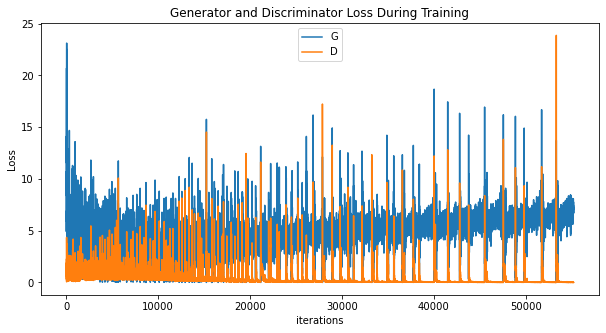

In [17]:
plot_losses(G_losses, D_losses)

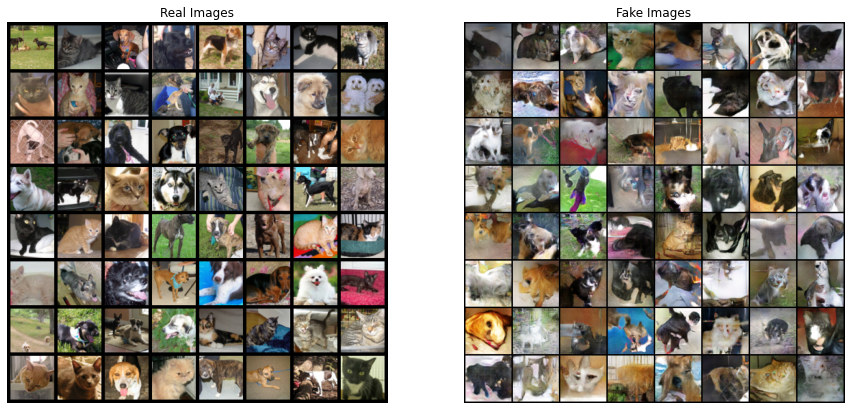

In [18]:
compare_real_gen(dataloader, img_list)

In [19]:
torch.save(netG.state_dict(), "unc_netG")
torch.save(netD.state_dict(), "unc_netD")
torch.save(img_list,          "unc_img_list")